In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'), 
    ('order_items.csv', 'order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/phane/OneDrive/Desktop/da project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [285]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [286]:
pip install mysql-connector-python


Note: you may need to restart the kernel to use updated packages.


In [288]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [289]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [291]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect( host = 'localhost',
                             username = 'root',
                             password = '12345',
                             database = 'ecommerce')

cur = db.cursor()



#  List of all unique cities where customers are located.                       

In [293]:
query = '''select distinct(customer_city) from customers'''

cur.execute(query)

data = cur.fetchall()

df =  pd.DataFrame(data, columns = ['city'])
df.head()
  

,city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.   

In [299]:
query = '''select count(order_id) from orders where year(order_purchase_timestamp) = 2017'''

cur.execute(query)

data = cur.fetchall()

data[0][0]
  

45101

# Total sales per category.


In [8]:
query = '''select p.product_category,
round(sum(ps.payment_value),2)
from products p
join order_items oi 
on p.product_id = oi.product_id 
join payments ps 
on ps.order_id = oi.order_id
group by p.product_category'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Categories', 'Sales'])
df

,Categories,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# The percentage of orders that were paid in installments.


In [43]:
query = '''select (sum(case when payment_installments > 0 then 1 else 0 end)/count(*))*100 as percentage 
from payments'''

cur.execute(query)

data = cur.fetchall()

'The percentage of orders that were paid in installments is', data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state. 

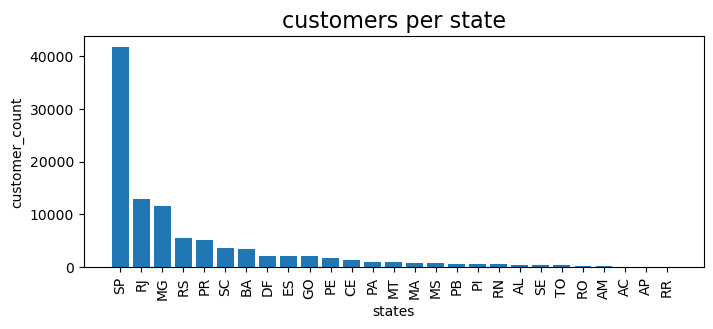

In [313]:
query = '''select customer_state, count(customer_id)
from customers 
group by customer_state'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['state', 'customer_count'])
df = df.sort_values(by = 'customer_count', ascending = False)
plt.figure(figsize = (8,3))
plt.bar(df['state'], df['customer_count'])
plt.xticks(rotation = 90)
plt.xlabel('states')
plt.ylabel('customer_count')
plt.title('customers per state',  fontsize=16)
plt.show()


 # Number of orders per month in 2018.  

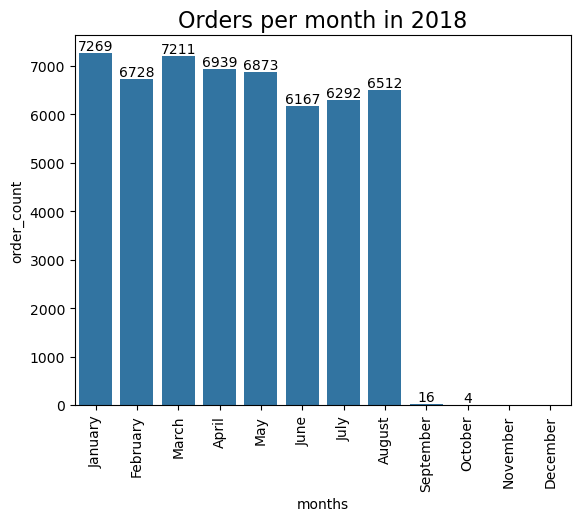

In [311]:
query = '''select monthname(order_purchase_timestamp) as months, count(order_id) as order_count from orders
where year(order_purchase_timestamp) = 2018 
group by months'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['months', 'order_count'])
o = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

ax = sns.barplot(x = df['months'], y = df['order_count'], data = df, order = o)
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title('Orders per month in 2018',  fontsize=16) 
plt.show()


# Average number of products per order, grouped by customer city. 

In [91]:
query = '''with orders_per_order  as 
(select o.order_id, o.customer_id, count(oi.order_id) as oc
from orders o join order_items oi
on o.order_id = oi.order_id
group by o.order_id, o.customer_id)

select c.customer_city, round(avg(orders_per_order.oc),2) as average_orders
from customers c join orders_per_order 
on c.customer_id = orders_per_order.customer_id
group by c.customer_city
order by average_orders desc'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = [ 'city' , 'avg_products_per_order' ])
df
import numpy as np

# The percentage of total revenue contributed by each product category. 

In [67]:

query = '''with total_revenue as 
(select sum(payment_value) as revenue from payments)

select upper(p.product_category), round((sum(py.payment_value)*100/tr.revenue),2) as contributed_revenue from order_items oi
join products p on p.product_id = oi.product_id
join payments py on py.order_id = oi.order_id
cross join total_revenue tr
group by p.product_category, tr.revenue
order by contributed_revenue desc'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['category', 'sales percentage' ])
df.head(5)

,category,sales percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# The correlation between product price and the number of times a product has been purchased. 

In [97]:
query = '''select p.product_category, count(oi.product_id), round(avg(oi.price),2)
from order_items oi
join  products p 
on p.product_id = oi.product_id
group by p.product_category'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'total_orders', 'price'])
arr1 = df['total_orders']
arr2 = df['price']
corr = np.corrcoef([arr1,arr2])
print('the correlation between product price and and the number of times a product has been purchased is', corr[0][1])


the correlation between product price and and the number of times a product has been purchased is -0.10631514167157562


# Total revenue generated by each seller, and rank them by revenue.


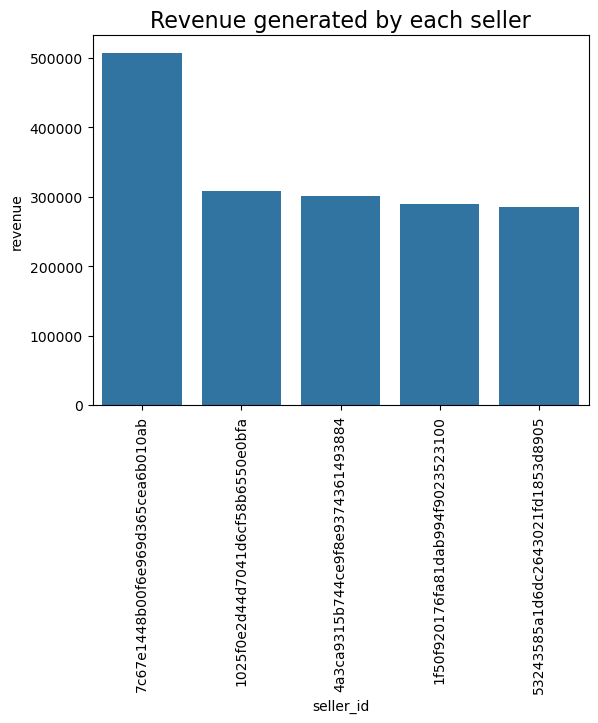

In [309]:
query = '''select a.* , dense_rank() over(order by a.revenue desc) as rnk from 
(select oi.seller_id, sum(p.payment_value) as revenue
from order_items oi
join payments p on p.order_id = oi.order_id
group by seller_id ) as a'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ['seller_id', 'revenue', 'rank'])
df = df.head()
sns.barplot(x= 'seller_id', y= 'revenue', data= df)
plt.xticks(rotation = 90)
plt.title('Revenue generated by each seller', fontsize=16)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [164]:
query = ''' select customer_id, timestamp, payment,  
avg(payment) over(partition by customer_id order by timestamp rows between 2 preceding and current row) as mov_avg
 from
 (select o.customer_id, o.order_purchase_timestamp as timestamp, p.payment_value as payment
from orders o
join payments p on o.order_id = p.order_id)  as a'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['customer_id', 'timestamp', 'moving avg of payments', 'payment'])
df

,customer_id,timestamp,moving avg of payments,payment
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [187]:
query = ''' select year, month, round(sales,2),
round(sum(sales) over(order by year, month),2) as cumulative_sales from
(select year(o.order_purchase_timestamp) as year, 
month(o.order_purchase_timestamp) as month,
sum(p.payment_value) as sales
from orders o 
join payments p on p.order_id = o.order_id
group by year, month) as a'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['year', 'month', 'sales', 'cumulative_sales'])
df

,year,month,sales,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.  


In [206]:
query = ''' with a as (select year(o.order_purchase_timestamp) as year,
round(sum(p.payment_value),2) as sales
from orders o 
join payments p on o.order_id = p.order_id
group by year)
select a.year, a.sales, 
((a.sales-lag(sales) over(order  by year))/lag(sales) over(order  by year))*100 as growth_rate
from a'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['year', 'sales', 'yoy % sales growth'])
df

,year,sales,yoy % sales growth
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


# The retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.  

In [229]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()


print('No customer bought more than one time within a span of 6 months, 
hence retention rate is shown as', data)

No customer bought more than one time within a span of 6 months, hence retention rate is shown as [(None,)]


# Top 3 customers who spent most in last 3 years. 

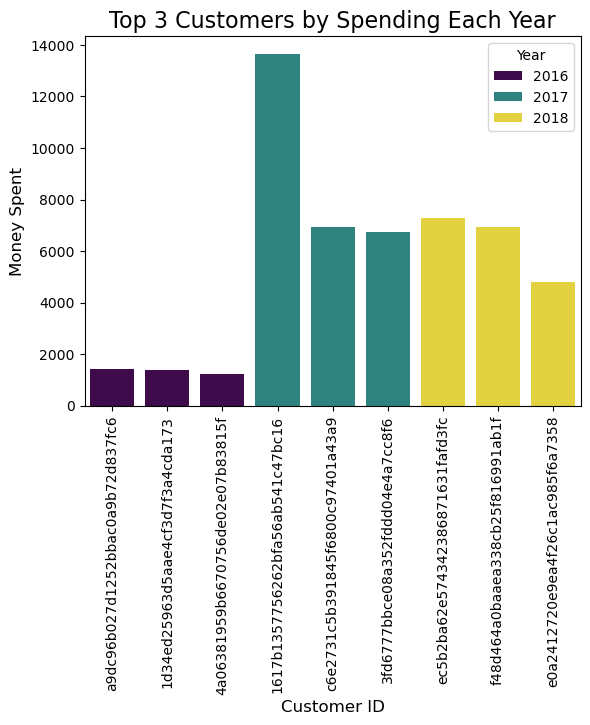

In [307]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years", palette='viridis')
plt.xticks(rotation = 90)
# titles and labels
plt.title('Top 3 Customers by Spending Each Year', fontsize=16)
plt.xlabel('Customer ID', fontsize=12)
plt.ylabel('Money Spent', fontsize=12)
plt.legend(title='Year', fontsize=10)


# Display the plot

plt.show()

